In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Lecture on Justice 40

Notebook developed by Dan Hammer. Adopted for ECON 148 (Spring 2023) by Peter F.G Hollevik.

## Part 1: Lead Paint Exposure

The Biden Administration [released a memo](https://www.whitehouse.gov/briefing-room/statements-releases/2021/01/27/fact-sheet-president-biden-takes-executive-actions-to-tackle-the-climate-crisis-at-home-and-abroad-create-jobs-and-restore-scientific-integrity-across-federal-government/) within the first week of their term, which addressed environmental justice. The two most important items for this class are:

> The order creates a government-wide Justice40 Initiative with the goal of delivering 40 percent of the overall benefits of relevant federal investments to disadvantaged communities and tracks performance toward that goal through the establishment of an Environmental Justice Scorecard.

> The order initiates the development of a Climate and Environmental Justice Screening Tool, building off EPA’s EJSCREEN, to identify disadvantaged communities, support the Justice40 Initiative, and inform equitable decision making across the federal government
    
It is very, very difficult - maybe even impossible - to **quantify environmental justice**, or even what constitutes a *disadvantaged community*. The EPA has tried. There are **fundamental issues** with their data and their math. We can begin to show why and how.

First, read in the data from a local directory. I have cleaned the data.

In [2]:
df = pd.read_csv("EJSCREEN_demo.csv")
df.head()

,ID,P_LDPNT,P_LDPNT_D2,VULEOPCT
0,10010201001,60.382488,38.762556,0.274371
1,10010201002,41.403686,32.680975,0.189588
2,10010202001,45.651211,74.665031,0.588895
3,10010202002,66.398228,78.826782,0.471891
4,10010203001,35.884283,44.665845,0.324309


This snippet of data contains:

> `P_LDPNT`: Percentile for % pre-1960 housing (lead paint indicator)

> `P_LDPNT`: Percentile for EJ Index for % pre-1960 housing (lead paint indicator)

> `VULEOPCT`: Demographic Index (based on 2 factors, % low-income and % people of color)

The index that the EPA uses to **prioritize communities** for Federal funding is based on a simple, algebraic expression:

$$\mbox{justice} = \mbox{environmental quality } \times \mbox{ demographic index } \times \mbox{ population}$$

where 

$$\mbox{demographic index} = \frac{[\% \mbox{minority}] + [\% \mbox{living below 2x federal poverty line}]}{2} - \mbox{ [national average]}$$

Just looking at this expression, you can imagine that there are some strange edge cases - communities that are **on the border of the national average of demographics** that have very different prioritization outcomes.  The data dictionary can be [downloaded directly from the EPA's FTP servers](https://gaftp.epa.gov/EJSCREEN/2020/2020_EJSCREEEN_columns-explained.xlsx).

First, create a demographic index in line with the EPA's equation, as well as a variable that indicates whether the Census block has particularly high values of lead paint exposure (above the 90th percentile).

We define our `demo_index` as follows:

> `VULEOPCT` $-$ mean(`VULEOPCT`)

In [3]:
df["demo_index"] = df.VULEOPCT - df.VULEOPCT.mean()
df["index_thresh"] = np.where(df.P_LDPNT > 90, True, False)
df.head()

,ID,P_LDPNT,P_LDPNT_D2,VULEOPCT,demo_index,index_thresh
0,10010201001,60.382488,38.762556,0.274371,-0.077346,False
1,10010201002,41.403686,32.680975,0.189588,-0.162129,False
2,10010202001,45.651211,74.665031,0.588895,0.237178,False
3,10010202002,66.398228,78.826782,0.471891,0.120174,False
4,10010203001,35.884283,44.665845,0.324309,-0.027408,False


### Raw Lead Paint Exposure vs. EPA Lead Paint Exposure Index

We use `matplotlib` to plot the percentile of raw lead paint values for Census blocks against the EPA index based on lead paint exposure. Color the values for Census blocks with the highest levels of exposure to environmental harm.  A lot of the spread is driven by the demographic index (which isn't presented in this graph, but drives the value of the EPA index.)

> Census blocks with the highest levels of lead paint are highlighted in yellow.


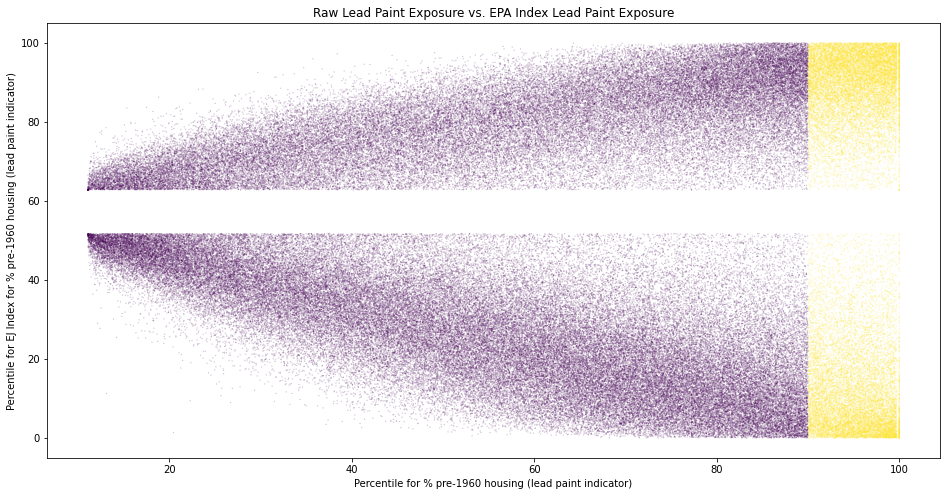

In [5]:
plt.figure(figsize=(16, 8))
plt.scatter(
    df.P_LDPNT, 
    df.P_LDPNT_D2, 
    s=0.01, 
    c=df.index_thresh
);
plt.xlabel('Percentile for % pre-1960 housing (lead paint indicator)')
plt.ylabel('Percentile for EJ Index for % pre-1960 housing (lead paint indicator)')
plt.title('Raw Lead Paint Exposure vs. EPA Index Lead Paint Exposure');

### EPA Lead Paint Exposure Index vs. Demographic Index

We plot the lead paint index against the demographic index. The majority of variation in the Lead Paint EJ Index (y-axis) is driven by the **Demographic Index (x-axis) used by EJSCREEN**, with a sharp discontinuity that is driven by whether a census block falls above or below the national average. 

The horizontal bar near the 60th percentile in this case is for **census blocks with zero lead paint exposure.** Census blocks with the highest levels of lead paint are highlighted in yellow.

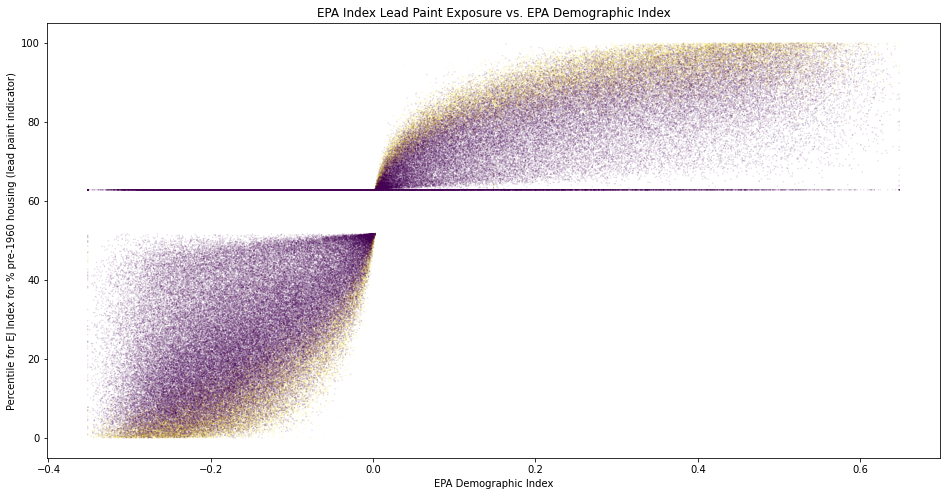

In [6]:
plt.figure(figsize=(16, 8))
plt.scatter(
    df.demo_index, 
    df.P_LDPNT_D2, 
    s=0.005, 
    c=df.index_thresh
)
plt.xlabel('EPA Demographic Index')
plt.ylabel('Percentile for EJ Index for % pre-1960 housing (lead paint indicator)')
plt.title('EPA Index Lead Paint Exposure vs. EPA Demographic Index');

The punchline is that, even if a Census block has an **extreme amount of lead paint exposure** (an environmental catastrophe), it won't be considered as part of the Justice40 funding if it falls (even slightly) on the privileged side of the National Average.  There is a sharp discontinuity.

> Remember, higher demographic index indicates a more marginalized community. Yellow indicates above 90th percentile in raw lead pain exposure. Several of these communities will not receive EJ support due to low demographic index.

There are no sharp discontinuities in the real-world, especially in justice-related work. We don't know what the right answer is, but it can't be this.

## Part 2: Urban, Suburban, vs. Rural

The EJSCREEN indices are used to prioritize federal funding in order to mitigate environmental injustice. 

Here, we examine the rural and urban representation in the prioritization data.

> We ask: Does this reflect the composition of the United States?  

First, read in a dataset that associates each U.S. county with a CDC assessment of urban/suburban/rural. The counties are uniquely identified by a Federal Information Processing System (FIPS) Code. 

In [8]:
# Source: https://www.cdc.gov/nchs/data_access/urban_rural.htm#Data_Files_and_Documentation
nchs = pd.read_excel("NCHSURCodes2013.xlsx")
nchs = nchs[["FIPS code", "State Abr.", "County name", "2013 code"]]
nchs.columns = ["fips", "state", "county", "classification"]
nchs.head()

,fips,state,county,classification
0,1001,AL,Autauga County,3
1,1003,AL,Baldwin County,4
2,1005,AL,Barbour County,6
3,1007,AL,Bibb County,2
4,1009,AL,Blount County,2


In [9]:
# Associate each of the classifications to one of three categories, rather 
# than one of six - just to simplify our quick analysis
remap_dict = {
    1: "urban",
    2: "suburban",
    3: "suburban",
    4: "rural",
    5: "rural",
    6: "rural"
}

# replace the values of the `classification` column based on the key-value 
# pair in `remap_dict`
nchs = nchs.replace({'classification': remap_dict})
nchs.head()

,fips,state,county,classification
0,1001,AL,Autauga County,suburban
1,1003,AL,Baldwin County,rural
2,1005,AL,Barbour County,rural
3,1007,AL,Bibb County,suburban
4,1009,AL,Blount County,suburban


Now, read in the EJ indices and merge the dataset with the urban/suburban/rural dataset, so that each of the Census Blocks in the EJSCREEN data now has the CDC categorization.

In [10]:
ejdf = pd.read_csv("EJSCREEN_sample.csv")
ejdf = ejdf.merge(nchs, how='left', on='fips')
ejdf.head()

,P_LDPNT_D2,P_DSLPM_D2,P_CANCR_D2,P_RESP_D2,P_PTRAF_D2,P_PWDIS_D2,P_PNPL_D2,P_PRMP_D2,P_PTSDF_D2,P_OZONE_D2,P_PM25_D2,fips,ACSTOTPOP,state,county,classification
0,38.762556,52.082627,48.818057,46.232065,44.619554,NaN,46.453526,55.357501,44.715359,54.266013,52.590207,1001,636,AL,Autauga County,suburban
1,32.680975,34.510043,18.078493,13.778821,51.604781,NaN,28.294803,47.823104,32.868597,36.571152,28.227514,1001,1287,AL,Autauga County,suburban
2,74.665031,69.357727,76.794353,78.753971,60.548840,NaN,74.556242,63.310599,69.778228,70.131713,72.825062,1001,810,AL,Autauga County,suburban
3,78.826782,67.369645,73.208783,75.000866,69.767028,NaN,72.941103,62.699549,70.557726,67.598876,69.839792,1001,1218,AL,Autauga County,suburban
4,44.665845,45.488143,41.645460,37.552262,43.599889,NaN,40.703356,53.955130,33.176275,51.540384,48.470685,1001,2641,AL,Autauga County,suburban


In [11]:
# A dictionary to translate opaque variable names to something that
# is human-readable
ejvars_dict = {
    'P_LDPNT_D2': 'Lead Paint',
    'P_DSLPM_D2': 'Diesel Particulate Matter',
    'P_CANCR_D2': 'Air Toxics Cancer Risk',
    'P_RESP_D2':  'Respiratory Hazard',
    'P_PTRAF_D2': 'Traffic Proximity',
    'P_PWDIS_D2': 'Water Discharge',
    'P_PNPL_D2':  'National Priority List',
    'P_PRMP_D2':  'Risk Management Plan',
    'P_PTSDF_D2': 'Treatment Storage and Disposal',
    'P_OZONE_D2': 'Ozone Proximity',
    'P_PM25_D2':  'PM25'
}

Each of the variables in the dataset indicates the percentile where that Census Block falls in prioritization. 

Those census blocks with high percentiles are prioritized for federal funding.  

Here, we examine the urban/suburban/rural breakdown of the population living within these high-priority Census Blocks.

In [12]:
v = 'P_LDPNT_D2'
temp_df = ejdf[ejdf[v] > 90]
temp_df = temp_df.groupby('classification').sum()['ACSTOTPOP'] # ACSTOTPOP: Total population

# add back in the classification variable for future reference
temp_dict = dict(temp_df)
temp_dict['classification'] = v
temp_dict

{'rural': 2159353,
 'suburban': 8769330,
 'urban': 21362290,
 'classification': 'P_LDPNT_D2'}

In [13]:
# Instead of just displaying the results for one variable, collect 
# the results for all in a list.
res = []

# Note that ejvars_dict.keys() is a list of the EJ variable names
for v in ejvars_dict.keys():
    temp_df = ejdf[ejdf[v] > 90] # filter for prioritized communities.
    temp_df = temp_df.groupby('classification').sum()['ACSTOTPOP']
    temp_dict = dict(temp_df)
    temp_dict['classification'] = v
    res.append(temp_dict)

# Create a dataframe of the results
graphing_df = pd.DataFrame(res)
graphing_df

,rural,suburban,urban,classification
0,2159353,8769330,21362290,P_LDPNT_D2
1,358539,8593184,23329310,P_DSLPM_D2
2,2116580,11012158,19152297,P_CANCR_D2
3,2076324,10708628,19495515,P_RESP_D2
4,491038,8866869,22933011,P_PTRAF_D2
5,3829551,11166090,17275490,P_PWDIS_D2
6,1580116,10192692,20513568,P_PNPL_D2
7,2231688,11590671,18468443,P_PRMP_D2
8,426142,6697207,25167032,P_PTSDF_D2
9,2416940,11462835,18195082,P_OZONE_D2


Here's a snippet from the [codebook](https://gaftp.epa.gov/EJSCREEN/2020/2020_EJSCREEEN_columns-explained.xlsx) on the meaning of each variable above.

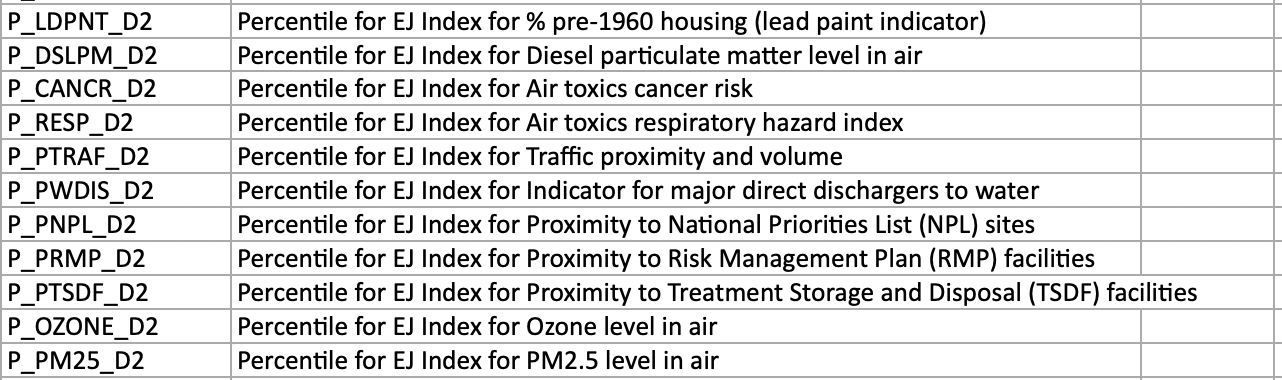

We now have a dataframe with the total population in rural, suburban, and urban areas **that would be prioritized for EJ funding for each of the 11 indicators.** Now, convert this into a percentage, noting that we can't just divide by the total population of the United States across all of these cell values due to missing values - and the fact that those missing values aren't uniformly distributed across the indicators.

In [14]:
pop_df = graphing_df[["rural", "suburban", "urban"]]

# first sum over the columns, horizontally
total_by_class = pop_df.sum(axis="columns")

# then divide, within columns, vertically
pop_df = pop_df.div(total_by_class, axis="index")

# add back the classification
pop_df["classification"] = graphing_df["classification"]

# name it appropriately
pop_df["indicators"] = pop_df.classification.replace(ejvars_dict)

pop_df

,rural,suburban,urban,classification,indicators
0,0.066872,0.271572,0.661556,P_LDPNT_D2,Lead Paint
1,0.011107,0.266199,0.722694,P_DSLPM_D2,Diesel Particulate Matter
2,0.065567,0.341134,0.593299,P_CANCR_D2,Air Toxics Cancer Risk
3,0.064321,0.331737,0.603942,P_RESP_D2,Respiratory Hazard
4,0.015207,0.274593,0.710200,P_PTRAF_D2,Traffic Proximity
5,0.118668,0.346009,0.535323,P_PWDIS_D2,Water Discharge
6,0.048941,0.315696,0.635363,P_PNPL_D2,National Priority List
7,0.069112,0.358947,0.571941,P_PRMP_D2,Risk Management Plan
8,0.013197,0.207406,0.779397,P_PTSDF_D2,Treatment Storage and Disposal
9,0.075353,0.357378,0.567269,P_OZONE_D2,Ozone Proximity


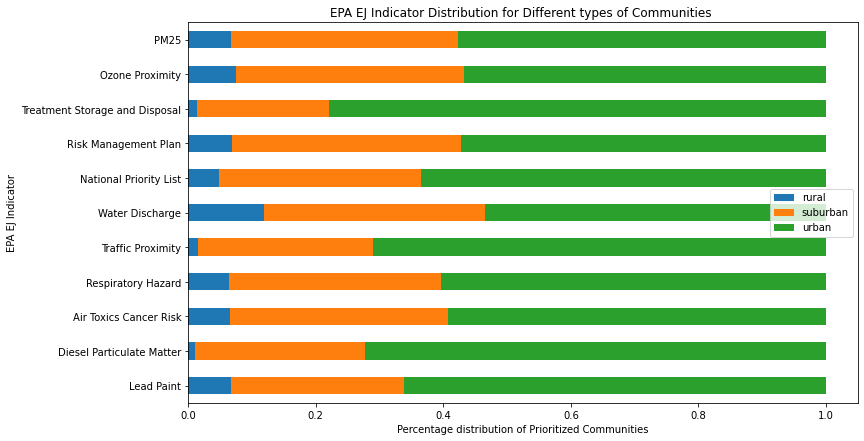

In [16]:
# Plot the results. 
pop_df = pop_df.set_index(pop_df.indicators)

pop_df.plot(figsize=(12, 7),
    kind="barh", 
    stacked=True
);

plt.xlabel('Percentage distribution of Prioritized Communities')
plt.ylabel('EPA EJ Indicator')
plt.title('EPA EJ Indicator Distribution for Different types of Communities ');

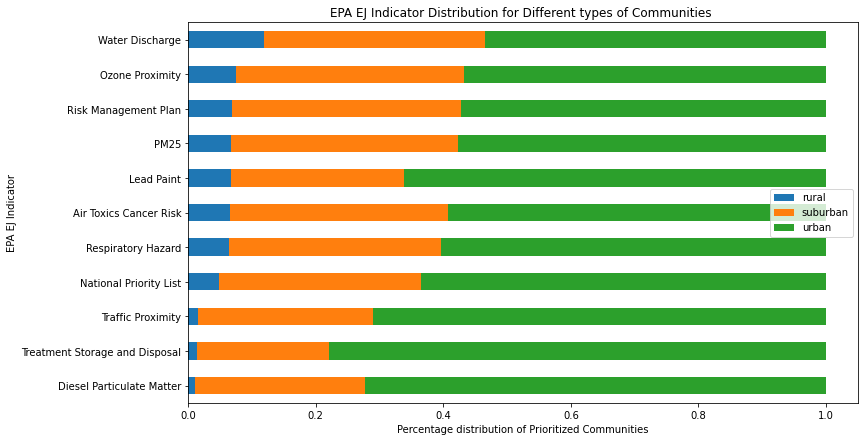

In [17]:
# replot the results, but sorting the bars by rural values
pop_df.sort_values(by=['rural']).plot(figsize=(12, 7),
    kind="barh", 
    stacked=True
);
plt.xlabel('Percentage distribution of Prioritized Communities')
plt.ylabel('EPA EJ Indicator')
plt.title('EPA EJ Indicator Distribution for Different types of Communities ');

Does this plot reflect the composition rest of the country? We can check!

In [18]:
ejdf.groupby("classification").sum()["ACSTOTPOP"] / sum(ejdf["ACSTOTPOP"])

classification
rural       0.231544
suburban    0.453165
urban       0.304910
Name: ACSTOTPOP, dtype: float64

The answer is: **No.**

## Part 3: Predicting the EJ Score

The objective is to fit a line that is defined by $y=mx+b$ so that the coefficient $m$ and the intercept $b$ are chosen to minimize the errors between the line and the actual observations.  We use ordinary least squares to find the slope and intercept of this line - the linear model.  There may be other types of models that better represent the data than a linear model; but a linear model is a good first start, just to get a sense of the data.

Once we have found the $m$ and $b$ that minimize the errors, which we call $\hat{m}$ and $\hat{b}$, we get a predicted $y$ value for each $x$.  We denote and calculate this predicted $y$ value as $\hat{y} = \hat{m} x + \hat{b}$. Note that the $x$ value isn't estimated.  It's just the data.  And therefore has no hat on it.

For a particular record, with index $i$, calculate the predicted $y$ value for that observation as $\hat{y}_i = \hat{m} x_i + \hat{b}$.  Note that the values of $\hat{m}$ and $\hat{b}$ are constant across all observations and, as a result, don't need the $i$ index.

Finally, we denote $\bar{y}$ as the mean for the $y$ variable, across all observations.

In [97]:
m, b, _, _, _ = stats.linregress(df.PM25, df.D_PM25_2)
print(f"slope: {m}")
print(f"intercept: {b}")

slope: 620.0056991018271
intercept: -5110.557334718794


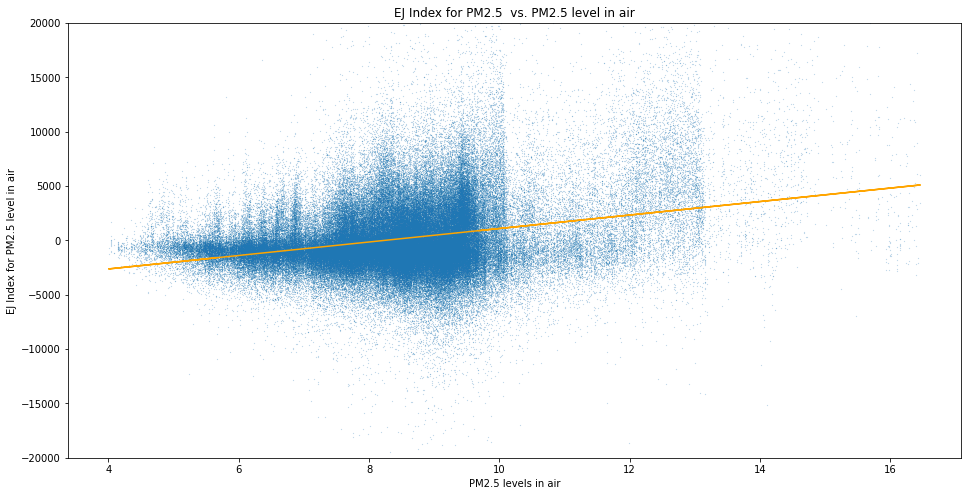

In [98]:
plt.figure(figsize=(16, 8))
plt.scatter(
    df.PM25,
    df.D_PM25_2,
    s=0.01
)

plt.plot(df.PM25, m*df.PM25 + b, color="orange")
plt.ylim([-20000, 20000])
plt.xlabel('PM2.5 levels in air')
plt.ylabel('EJ Index for PM2.5 level in air')
plt.title('EJ Index for PM2.5  vs. PM2.5 level in air');

In [83]:
m, b, _, _, _ = stats.linregress(df.demographic_index, df.D_PM25_2)
print(f"slope: {m}")
print(f"intercept: {b}")

slope: 12503.34179112213
intercept: 141.8040772768265


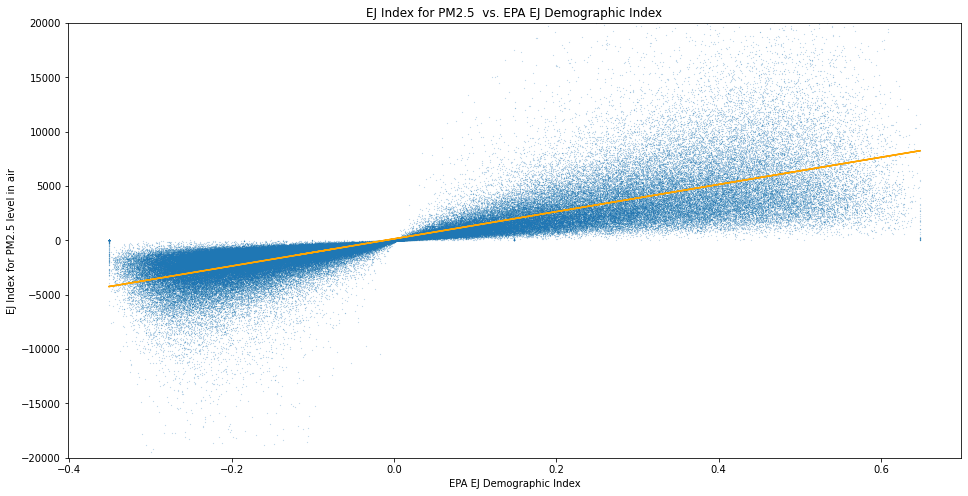

In [95]:
plt.figure(figsize=(16, 8))
plt.scatter(
    df.demographic_index,
    df.D_PM25_2,
    s=0.01
)
plt.plot(df.demographic_index, m*df.demographic_index + b, color="orange")
plt.ylim([-20000, 20000])
plt.xlabel('EPA EJ Demographic Index')
plt.ylabel('EJ Index for PM2.5 level in air')
plt.title('EJ Index for PM2.5  vs. EPA EJ Demographic Index');

## Part 4: Bonus on $R^2$

The R-squared, or coefficient of correlation, or coefficient of determination is a measure of **how much of the variation can be explained by the linear model**.  A higher $R^2$ value indicates that the linear model explains more of the variation - there is less variation relegated to the residuals, relative to the total variation.

$$ R^2 = 1 - \frac{RSS}{TSS} = 1 - \frac{\sum_{i} (y_i - \hat{y}_{i})^{2}}{\sum_{i} (y_i - \bar{y})^{2}}$$



In [84]:
m, b, _, _, _ = stats.linregress(df.PM25, df.D_PM25_2)
df["yhat"] = m*df.PM25 + b
rss = np.sum((df.D_PM25_2 - df.yhat)**2)
tss = np.sum((df.D_PM25_2 - df.D_PM25_2.mean())**2)

1 - rss/tss

0.0719694360088291

> Raw PM2.5 data explains approximately 7% of variation in EJ PM2.5 score. 

In [85]:
m, b, r, _, _ = stats.linregress(df.PM25, df.D_PM25_2)

r**2

0.0719694360088292

In [86]:
m, b, _, _, _ = stats.linregress(df.demographic_index, df.D_PM25_2)
df["yhat"] = m*df.demographic_index + b
rss = np.sum((df.D_PM25_2 - df.yhat)**2)
tss = np.sum((df.D_PM25_2 - df.D_PM25_2.mean())**2)

1 - rss/tss

0.6742545686316728

In [139]:
m, b, r, _, _ = stats.linregress(df.demographic_index, df.D_PM25_2)

r**2

0.6742545686316732

Should it?  I don't know.  But this very apparent mismatch is not being adequately addressed at the highest levels of government, as they discuss how to identify "underserved communities."

## Bonus Part 5: A Quick Look at the Raw Data

Let's get a more detailed look at the raw data used above than the `describe()` method affords.

In [70]:
df = pd.read_csv("EJSCREEN_sample2.csv")
df.describe()

,D_OZONE_2,D_PM25_2,OZONE,PM25,VULEOPCT,ACSTOTPOP,LOWINCPCT,MINORPCT,ID,demographic_index,fips
count,216046.000000,216046.000000,216046.000000,216046.000000,216046.000000,216046.000000,216046.000000,216046.000000,2.160460e+05,2.160460e+05,216046.000000
mean,119.334165,141.804077,42.809740,8.471473,0.351639,1484.420809,0.334941,0.368337,2.823431e+11,-1.437548e-16,28234.046842
std,16723.377651,3444.401415,6.582827,1.490363,0.226204,989.572104,0.211581,0.313300,1.569860e+11,2.262036e-01,15698.596138
min,-371198.063720,-90644.530105,24.953781,4.004773,0.000000,0.000000,0.000000,0.000000,1.001020e+10,-3.516392e-01,1001.000000
25%,-9157.996323,-1746.870154,39.409066,7.640961,0.170226,892.000000,0.164487,0.097070,1.311713e+11,-1.814132e-01,13117.000000
50%,-2796.255871,-538.105932,42.785367,8.514723,0.290369,1268.000000,0.303243,0.271214,2.810795e+11,-6.127004e-02,28107.000000
75%,7609.474718,1563.734759,45.509500,9.254419,0.507526,1818.000000,0.476502,0.603545,4.105100e+11,1.558864e-01,41051.000000
max,272045.350467,62799.333874,75.941846,16.459907,1.000000,55407.000000,1.000000,1.000000,5.604595e+11,6.483608e-01,56045.000000


1484


Text(0.5, 0, 'Total Census Population')

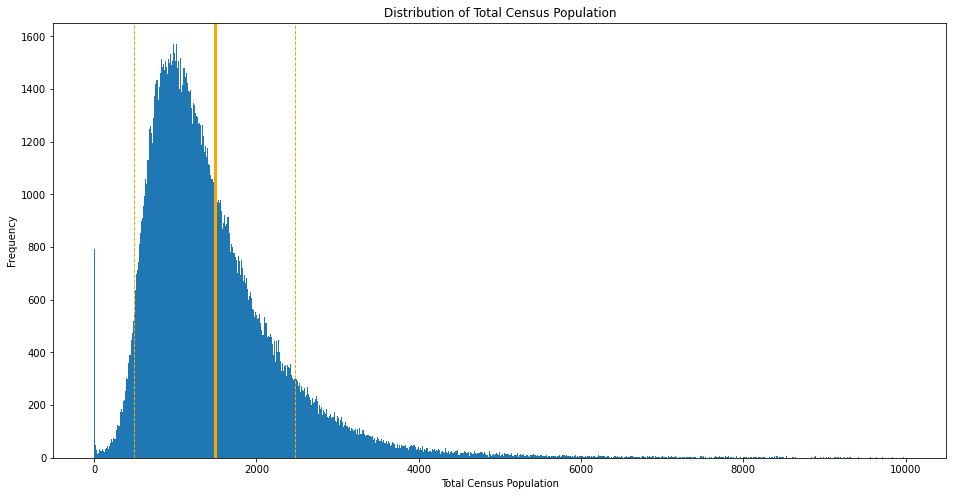

In [76]:
# Evolution of parameters fed into the plot
#     plt.hist(df.ACSTOTPOP)
#     plt.hist(df.ACSTOTPOP, range=[0,10000])

# Set figure size
plt.figure(figsize=(16, 8))

# Assign the plot to a variable, just to suppress output in Notebooks
fig = plt.hist(df["ACSTOTPOP"], range=[0,10000], bins=1000)

# Add a vertical line at the mean value, and standard deviations
plt.axvline(
    df.ACSTOTPOP.mean(), 
    linewidth=3, 
    color="orange"
)

plt.axvline(
    df.ACSTOTPOP.mean()-df.ACSTOTPOP.std(), 
    linewidth=1, 
    color="orange",
    linestyle="dashed"
)

plt.axvline(
    df.ACSTOTPOP.mean()+df.ACSTOTPOP.std(), 
    linewidth=1, 
    color="orange",
    linestyle="dashed"
)

print(int(df.ACSTOTPOP.mean()))

plt.title('Distribution of Total Census Population')
plt.ylabel('Frequency')
plt.xlabel('Total Census Population')

Text(0.5, 0, 'PM2.5 Concentrations in the Air')

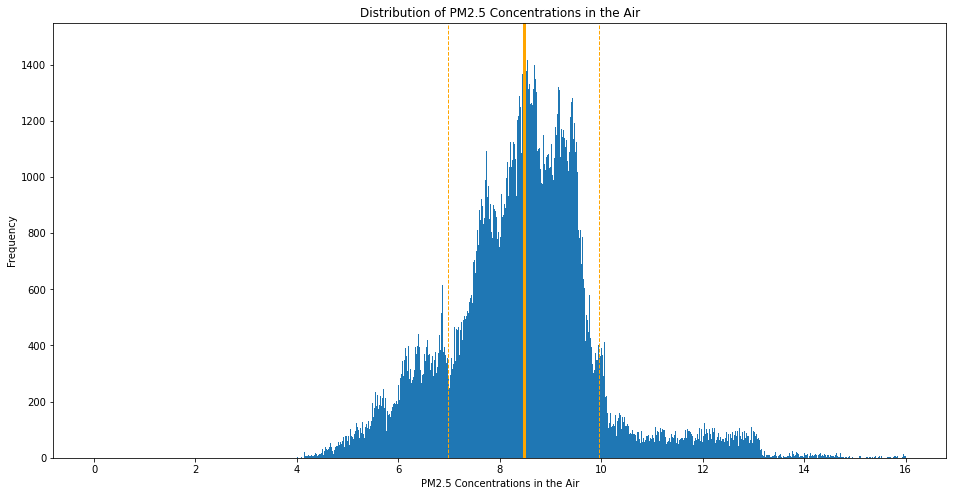

In [75]:
# Evolution of parameters fed into the plot
#     plt.hist(df.ACSTOTPOP)
#     plt.hist(df.ACSTOTPOP, range=[0,10000])

# Set figure size
plt.figure(figsize=(16, 8))

# Assign the plot to a variable, just to suppress output in Notebooks
fig = plt.hist(df.PM25, range=[0,16], bins=1000)

# Add a vertical line at the mean value, and standard deviations
plt.axvline(
    df.PM25.mean(), 
    linewidth=3, 
    color="orange"
)

plt.axvline(
    df.PM25.mean()-df.PM25.std(), 
    linewidth=1, 
    color="orange",
    linestyle="dashed"
)

plt.axvline(
    df.PM25.mean()+df.PM25.std(), 
    linewidth=1, 
    color="orange",
    linestyle="dashed"
)

plt.title('Distribution of PM2.5 Concentrations in the Air')
plt.ylabel('Frequency')
plt.xlabel('PM2.5 Concentrations in the Air')

## Bonus Part 6: Community Type and Demographic Factors.

In [19]:
# Source: https://www.cdc.gov/nchs/data_access/urban_rural.htm#Data_Files_and_Documentation
nchs = pd.read_excel("NCHSURCodes2013.xlsx")
nchs = nchs[["FIPS code", "State Abr.", "County name", "2013 code"]]
nchs.columns = ["fips", "state", "county", "classification"]

In [89]:
# Associate each of the classifications to one of three categories, rather 
# than one of six - just to simplify our quick analysis
remap_dict = {
    1: "urban",
    2: "suburban",
    3: "suburban",
    4: "rural",
    5: "rural",
    6: "rural"
}

# replace the values of the `classification` column based on the key-value 
# pair in `remap_dict`
nchs = nchs.replace({'classification': remap_dict})

In [90]:
ejdf = df.merge(nchs, on="fips")

urban: 0.34177089535301025
suburban: 0.29819076107418807
rural: 0.3841282110056917


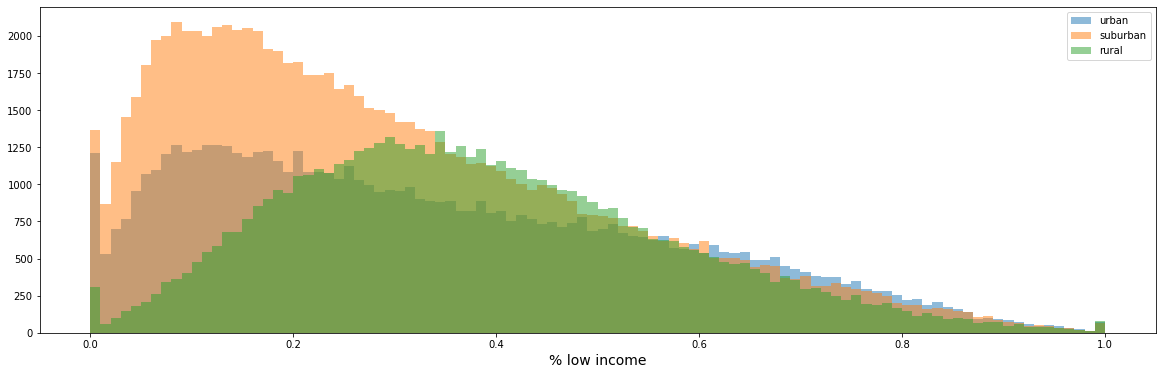

In [91]:
urban    = ejdf[ejdf.classification == "urban"].LOWINCPCT
suburban = ejdf[ejdf.classification == "suburban"].LOWINCPCT
rural    = ejdf[ejdf.classification == "rural"].LOWINCPCT

plt.figure(figsize=(20,6))
fig = plt.hist(urban, bins=100, alpha=0.5, label="urban")
fig = plt.hist(suburban, bins=100, alpha=0.5, label="suburban")
fig = plt.hist(rural, bins=100, alpha=0.5, label="rural")

plt.xlabel("% low income", size=14)
plt.legend(loc='upper right')

print(f"urban: {urban.mean()}")
print(f"suburban: {suburban.mean()}")
print(f"rural: {rural.mean()}")

urban: 0.5511409744033048
suburban: 0.33149629493118665
rural: 0.2204441200137107


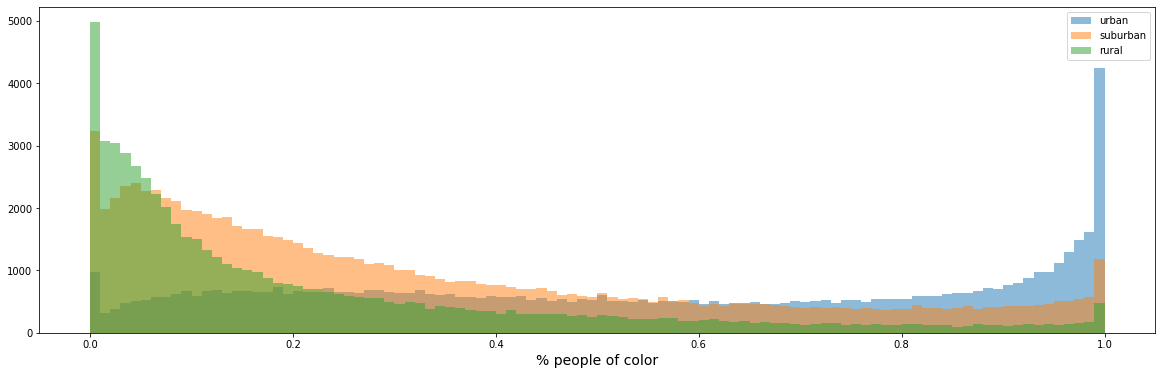

In [92]:
urban    = ejdf[ejdf.classification == "urban"].MINORPCT
suburban = ejdf[ejdf.classification == "suburban"].MINORPCT
rural    = ejdf[ejdf.classification == "rural"].MINORPCT

plt.figure(figsize=(20,6))
fig = plt.hist(urban, bins=100, alpha=0.5, label="urban")
fig = plt.hist(suburban, bins=100, alpha=0.5, label="suburban")
fig = plt.hist(rural, bins=100, alpha=0.5, label="rural")

plt.xlabel("% people of color", size=14)
plt.legend(loc='upper right')

print(f"urban: {urban.mean()}")
print(f"suburban: {suburban.mean()}")
print(f"rural: {rural.mean()}")